In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [9]:
# Load dataset
dataset = pd.read_csv('Room_Occupancy_Data.csv')  # Changed the file name
dataset.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [10]:
# Check dataset structure and handle missing values
print("Dataset shape:", dataset.shape)
print("Missing values per column:\n", dataset.isnull().sum())

Dataset shape: (10129, 19)
Missing values per column:
 Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64


In [11]:
# Drop unnecessary columns
dataset = dataset.drop(['Date', 'Time'], axis=1)

<Axes: xlabel='Room_Occupancy_Count', ylabel='count'>

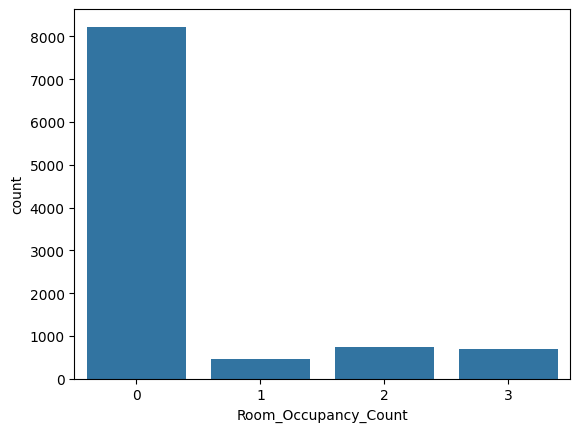

In [12]:
# Visualize the target variable distribution
sns.countplot(x='Room_Occupancy_Count', data=dataset)

In [13]:
# Separate features and target
X = dataset.iloc[:, :-1]
y = dataset['Room_Occupancy_Count']

In [14]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
# Generate multiple train-test splits
samples = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    samples.append((X_train, X_test, y_train, y_test))

In [16]:
# Initialize kernels for SVM
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
result = pd.DataFrame(columns=['Sample', 'Best Accuracy', 'Best Kernel', 'Best Nu', 'Best Epsilon'])


In [17]:
# Fitness function for SVM accuracy calculation
def fitness_function(kernel, C, gamma):
    svm = SVC(kernel=kernel, C=C, gamma=gamma, max_iter=1000)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return accuracy_score(y_pred, y_test)

In [18]:
# Perform optimization over samples
for i in range(len(samples)):
    best_accuracy = 0
    best_C = 0
    best_gamma = 0
    best_kernel = ""
    
    for kernel in kernels:
        X_train, X_test, y_train, y_test = samples[i]
        C = np.random.uniform(0.1, 10)  # Adjusted range slightly for better diversity
        gamma = np.random.uniform(0.1, 10)
        score = fitness_function(kernel, C, gamma)
        
        if score > best_accuracy:
            best_accuracy = round(score, 2)
            best_C = round(C, 2)
            best_gamma = round(gamma, 2)
            best_kernel = kernel

    print(f'Sample {i+1}: Best Accuracy = {best_accuracy}, Best Kernel = {best_kernel}, Best Nu = {best_C}, Best Epsilon = {best_gamma}')
    result.loc[i] = [i+1, best_accuracy, best_kernel, best_C, best_gamma]


Sample 1: Best Accuracy = 0.99, Best Kernel = linear, Best Nu = 8.28, Best Epsilon = 2.83
Sample 2: Best Accuracy = 0.99, Best Kernel = linear, Best Nu = 0.61, Best Epsilon = 6.43
Sample 3: Best Accuracy = 1.0, Best Kernel = linear, Best Nu = 1.19, Best Epsilon = 4.05
Sample 4: Best Accuracy = 0.99, Best Kernel = poly, Best Nu = 6.94, Best Epsilon = 4.37
Sample 5: Best Accuracy = 0.99, Best Kernel = poly, Best Nu = 5.94, Best Epsilon = 8.56
Sample 6: Best Accuracy = 1.0, Best Kernel = linear, Best Nu = 0.74, Best Epsilon = 3.55
Sample 7: Best Accuracy = 0.99, Best Kernel = linear, Best Nu = 1.2, Best Epsilon = 6.87
Sample 8: Best Accuracy = 0.99, Best Kernel = linear, Best Nu = 7.75, Best Epsilon = 2.21
Sample 9: Best Accuracy = 0.99, Best Kernel = poly, Best Nu = 3.65, Best Epsilon = 6.32
Sample 10: Best Accuracy = 0.99, Best Kernel = linear, Best Nu = 8.55, Best Epsilon = 9.98


In [19]:
# Select the sample with the best accuracy
X_train, X_test, y_train, y_test = samples[result['Best Accuracy'].idxmax()]

In [20]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    SVC(
        kernel=result['Best Kernel'].iloc[result['Best Accuracy'].idxmax()],
        C=result['Best Nu'].iloc[result['Best Accuracy'].idxmax()],
        gamma=result['Best Epsilon'].iloc[result['Best Accuracy'].idxmax()],
        max_iter=1000
    ),
    X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.01, 1.0, 50)
)

In [21]:
# Calculate mean training and cross-validation scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

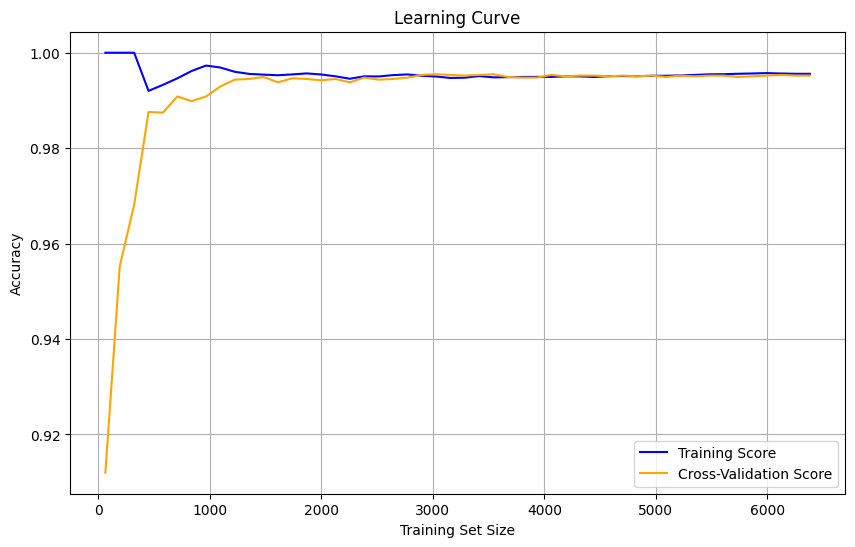

In [22]:
# Plot the convergence graph
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()